<h1> BrainStation Capstone Project</h1>

<b>Is the song "hot enough" for Billboard Hot100 🔥</b>
<br> Predicting the probability of a song reaching the Billboard Hot100 chart.</br>

Author: Hailey Lee
<br>Contact: ejlee.hailey@gmail.com
<br>Date: July 5, 2022

---

# Logistic Regression

As a reminder, our business question is answering the likelihood of a song reaching the Billboard Hot100 chart. And since the answer to that question can go two ways ("1" for yes Billboard, and "0" for no Billboard), we are dealing with a binary classification problem. While there are many other classification models (KNN, Decision Tree, etc.), we will start with Logistic Regression for the ease of interpretability. The coefficients of a Logistic Regression can help us calculate the odds ratio which in turn helps us understand the probability for each increase in $x$.

Note: We are not including the vectorized texts from song lyrics as features for this model. Text analysis is done in a separate Jupyter notebook for the sake of computation power and interpretability. 

---
#### Table of Contents:
* [Score Summary](#score)
* [Exploratory Data Analysis](#eda)
* Modeling
    * [Logistic Regression with Default Parameters](#logreg1)
    * [Logistic Regression with 'Release Year' Dropped](#logreg2)
    * [Logistic Regression with 'Release Year' Modified](#logreg3)
    * [Optimize Model with GridSearch](#grid)
    * [Logistic Regression with Combined Scalers](#logreg4)
* [Precision and Recall](#precision) (Supplementary)
---

### Score Summary<a class="anchor" id="score"></a>

|Model | Parameters / Changes | Train Set Score | Test Set Score |
|:-----|:---------------------|:---------------:|:--------------:|
|Logistic Regression | Default | 81.1% | 80.9% |
|Logistic Regression without `release_year` | Default | 80.1% | 80.4% |
|Logistic Regression with `release_year` modified| Default | 81.2% | 80.7% |
|Logistic Regression with CV Grid Search | C = 10, solver = 'saga' | 81.1% | 81.1% |
|Logistic Regression with Combined Scalers| C = 10,000 | 81.2% | 81.1% |

<br>
<br>
<center>Top Coefficients of the Model</center>

|    |Positive | Negative |
|:--:|:--------|:--------|
| 1. | Track Popularity | Duration (ms) |
| 2. | Genre - Screen | Release Year |
| 3. | Artist Popularity | Energy |
| 4. | Loudness | Genre - Indie |
| 5. | Genre - Country | Genre - Elect |
| 6. | Genre - Hip Hop | Genre - Punk |
| 7. | Artist Followers | Instrumentalness |
| 8. | Genre - Latin | Genre - Blues |
| 9. | Mode | Genre - Rock |
|10. | Tempo | Genre - Gospel |

---
### Exploratory Data Analysis<a class="anchor" id="eda"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn import set_config
from tempfile import mkdtemp

# ignore warning messages
import warnings
warnings.filterwarnings("ignore")

# view all columns
pd.set_option('display.max_columns', None)

In [2]:
songs_df = pd.read_csv('capstone_dataset_clean.csv')

In [3]:
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13807 entries, 0 to 13806
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   billboard          13807 non-null  int64  
 1   billboard_year     13807 non-null  int64  
 2   billboard_month    13807 non-null  int64  
 3   peak_position      13807 non-null  int64  
 4   weeks_on_chart     13807 non-null  int64  
 5   artist             13807 non-null  object 
 6   feat_artist        13807 non-null  object 
 7   artist_uri         13807 non-null  object 
 8   artist_popularity  13807 non-null  int64  
 9   artist_followers   13807 non-null  int64  
 10  song               13807 non-null  object 
 11  track_uri          13807 non-null  object 
 12  track_popularity   13807 non-null  int64  
 13  album_name         13807 non-null  object 
 14  release_year       13807 non-null  int64  
 15  release_month      13807 non-null  int64  
 16  duration_ms        138

In [4]:
# columns that are non-numeric
songs_df.columns[songs_df.dtypes == 'object']

Index(['artist', 'feat_artist', 'artist_uri', 'song', 'track_uri',
       'album_name'],
      dtype='object')

In [5]:
# drop non-numeric and billboard-exclusive columns
songs_num_df = songs_df.drop(columns=['artist', 'feat_artist', 'artist_uri', 'song', 'track_uri', 'album_name',
                                      'billboard_year', 'peak_position', 'weeks_on_chart', 'billboard_month'])

In [6]:
# look at sample row
songs_num_df.sample()

,billboard,artist_popularity,artist_followers,track_popularity,release_year,release_month,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,major_label,genre_pop,genre_screen,genre_hiphop,genre_punk,genre_blues,genre_country,genre_rnb,genre_rock,genre_latin,genre_dance,genre_indie,genre_elect,genre_gospel,genre_chill
5022,0,77,4362197,0,2015,12,240226,0.754,0.494,11,-9.502,1,0.0782,0.013,0.000317,0.417,0.24,139.983,4,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# let's define the target variable and features
X = songs_num_df.drop(columns='billboard')
y = songs_num_df['billboard']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (13807, 33)
Shape of y: (13807,)


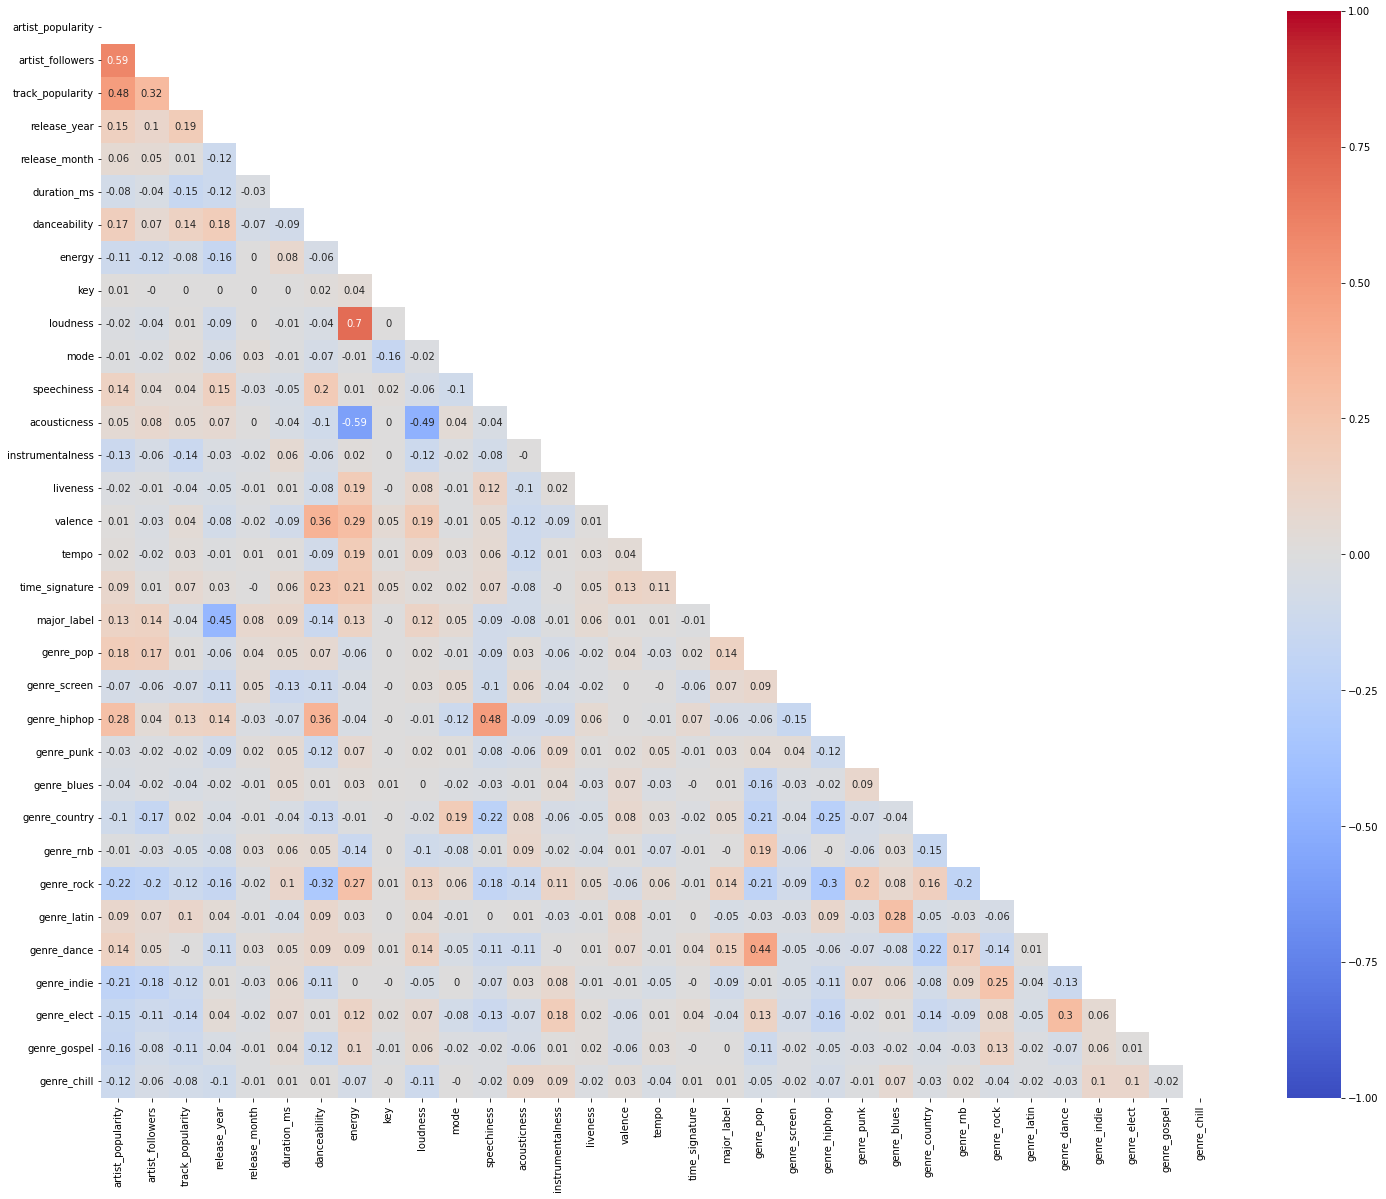

In [15]:
# look at correlation matrix
plt.figure(figsize=(25,20))
sns.heatmap(X.corr().round(2), vmin=-1, vmax=1, cmap='coolwarm', annot=True, mask=np.triu(X.corr()))
plt.show()

This is a heatmap of the correlation matrix of our X features. The numbers indicate the strength of the relationship between two variables. Zero equals no correlation, and 1 or -1 means high correlation. Fortunately, the multicollinearity is minimal to none, meaning no two features have a strong linear relationship with one another. If they did, the features would have been considered redundant information to the model. Regardless, let's take a look at the ones ones that are greater than |0.5|:
- artist_popularity and artist_followers have a positive correlation of 0.59
- loudness and energy have a positive correlation of 0.70
- acousticness and energy have a negative correlation of -0.59

Interesting but not surprising! Popular artists would attract more followers. Loud songs would project more energy than acoustic songs. 

Next, let's look at the distributions of each feature.

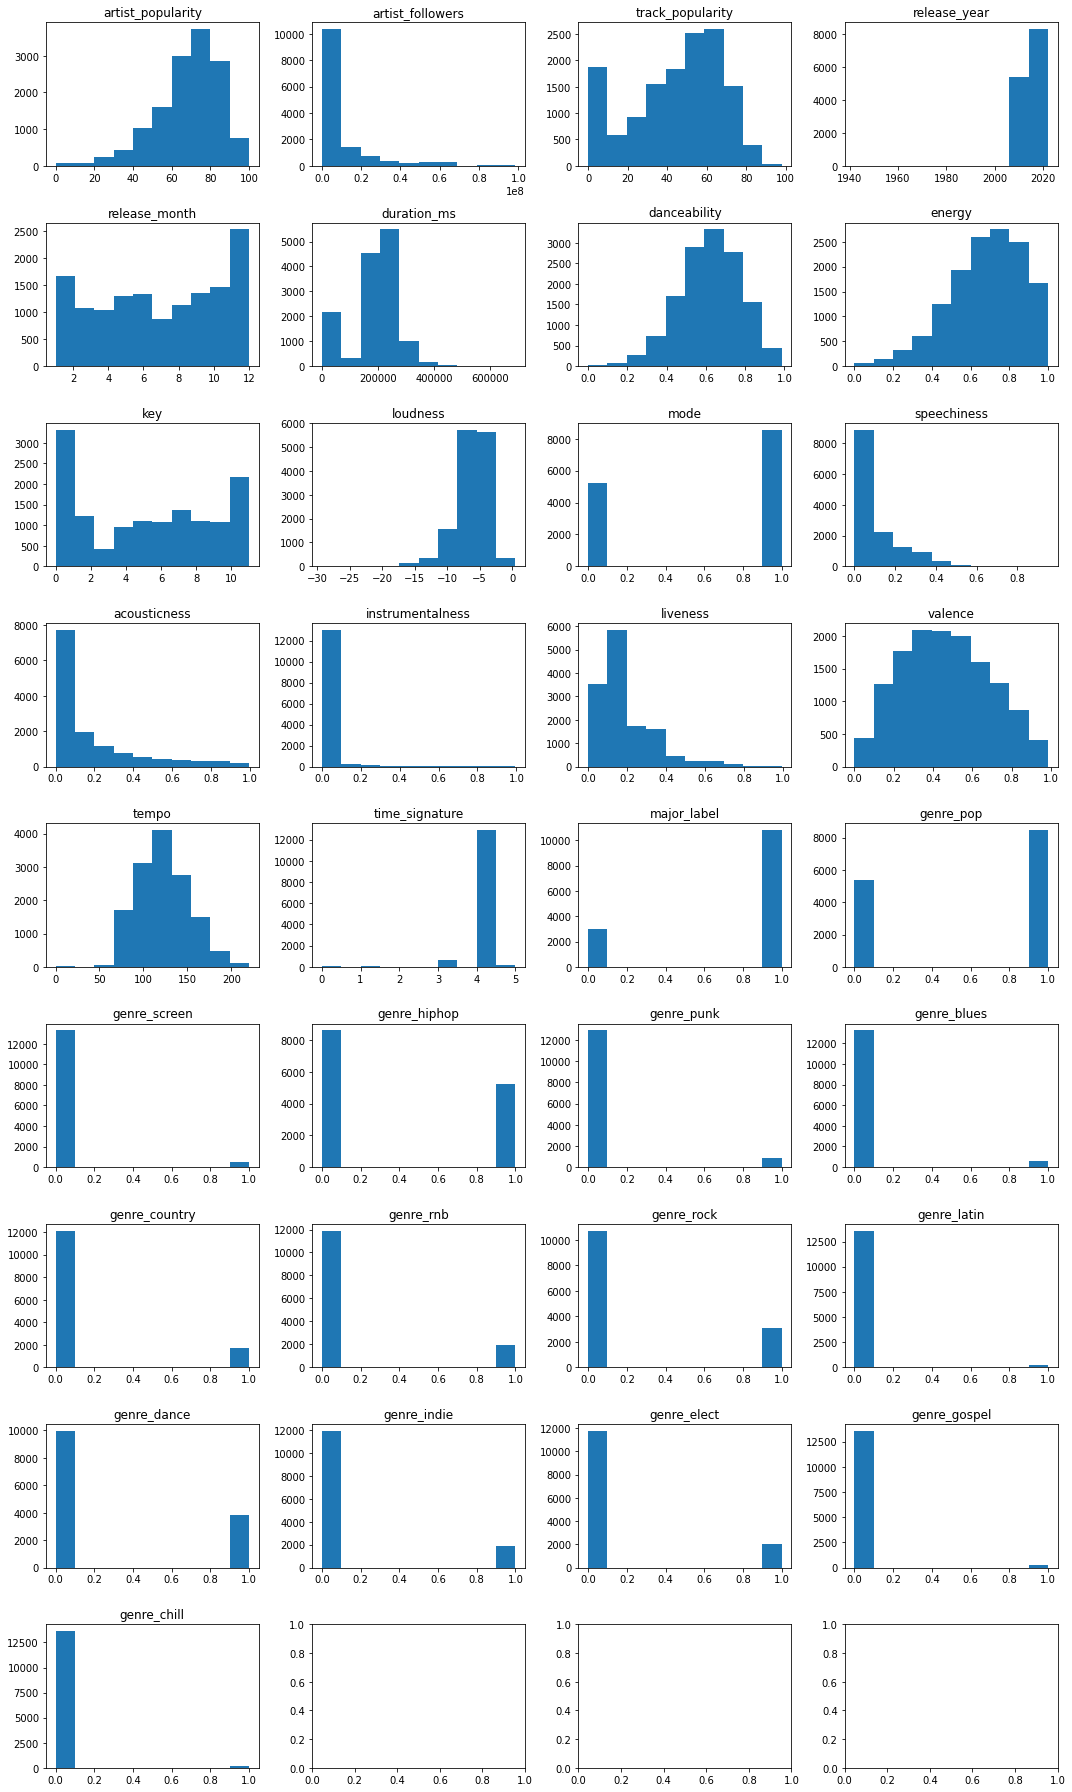

In [17]:
i = 1
plt.subplots(9,4,figsize=(15,25))

for column in X.columns:
    plt.subplot(9,4,i)
    plt.hist(X[column])
    plt.title(f'{column}')
    i += 1

plt.tight_layout()
plt.show()

Note: To understand how each feature is measured, please refer to the glossary.doc that came with this project.

We have a mix of different distributions. Plots like artist_popularity, track_popularity, danceability, energy, valence, and tempo all show signs of being a normal (or Gaussian) distribution with a central tendency. Plots like artist_followers, duration_ms, loudness, speechiness, acousticness, instrumentalness, and liveness show signs of being either right-skewed or left-skewed which means the data tends to bias more towards one side. The rest of the plots mainly have binary data (either 0's or 1's). This leaves a hanging question for our next -- which scaler should we use?

The `StandardScaler()` changes the distribution of the data such that the data is centered at zero (the mean) and has a variance or standard deviation of 1. The `MinMaxScale()` deals with the range of data and scales the data from 0 to 1. For our normally distributed data, we want to use the StandardScaler(); but for our binary data, we want to use the MinMaxScaler().

We will fit the StandardScaler first and compare against the MinMaxScaler later with GridSearch.

---
### Logistic Regression with Default Parameters<a class="anchor" id="logreg1"></a>

To avoid data leakage, let's being my splitting our train and test data:

In [8]:
# train test split 75/25
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 15,
                                                    stratify = y)

We will scale the data with the `StandardScaler()` first:

In [9]:
# 1. instantiate
scaler = StandardScaler()

# 2. fit the train set
scaler.fit(X_train)

# 3. transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now let's fit the scaled data to the `LogisticRegression` model with default parameters to set as our baseline.

In [10]:
# 1. instantiate
log_model = LogisticRegression(max_iter=1000)

# 2. fit on train set
log_model.fit(X_train_scaled, y_train)

# 3. score on train and test sets 
print(f'Train set accuracy: {round(log_model.score(X_train_scaled, y_train)*100,1)}%')
print(f'Test set accuracy: {round(log_model.score(X_test_scaled, y_test)*100,1)}%')

Train set accuracy: 81.2%
Test set accuracy: 81.2%


Not bad! Test set accuracy of 81.2% is a great number to start with, and there is no sign of overfitting either as the model scored evenly across both the train and test sets.

Let's explore this model a little more so we can interpret the impact of each feature by looking at its coefficients:

In [12]:
import plotly.express as px

In [34]:
pos_df = pd.DataFrame({'features':X_train.columns,'coefficients':log_model.coef_[0]}).sort_values(by='coefficients',ascending=False).head(3)
neg_df = pd.DataFrame({'features':X_train.columns,'coefficients':log_model.coef_[0]}).sort_values(by='coefficients',ascending=False).tail(3)
comb_df = pd.concat([pos_df,neg_df],axis=0)
comb_df.reset_index(inplace=True)
comb_df["color"] = np.where(comb_df['coefficients']<0, 'Negative', 'Positive')
comb_df

,index,features,coefficients,color
0,2,track_popularity,1.238890,Positive
1,20,genre_screen,0.451828,Positive
2,0,artist_popularity,0.378954,Positive
3,7,energy,-0.379043,Negative
4,3,release_year,-0.591616,Negative
5,5,duration_ms,-0.791962,Negative


In [37]:
fig = px.bar(data_frame=comb_df,
                 x='features',
                 y='coefficients',
             labels={'features':'Features',
                    'coefficients':'Coefficients',
                    'colo'},
             title='Logistic Regression: Strongest Coefficients',
            color='color')

fig.update_layout(plot_bgcolor = 'rgba(0, 0, 0, 0)' )

fig.update_xaxes(linewidth = 1, linecolor ='black')
fig.update_yaxes(linewidth = 1, linecolor ='black')
fig.show()

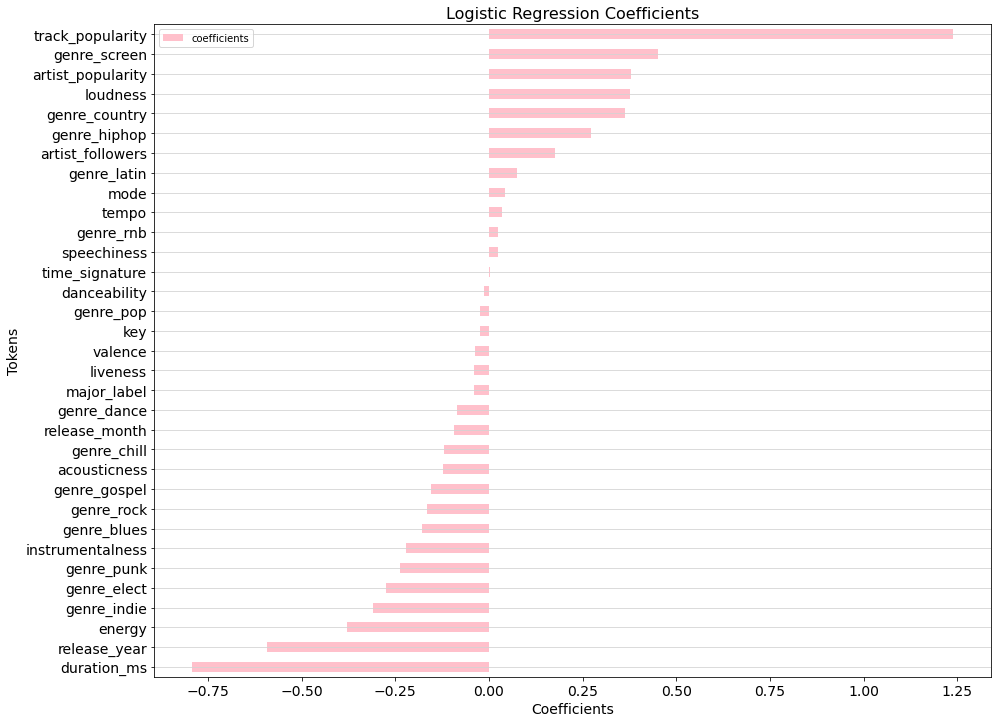

In [11]:
pd.DataFrame({
    'features':X_train.columns,
    'coefficients':log_model.coef_[0]}).sort_values(by='coefficients').plot(kind='barh',
                                                                           x='features',
                                                                           figsize=(15,12),
                                                                           fontsize=14,
                                                                           color='pink')
plt.title('Logistic Regression Coefficients', fontsize=16 )
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Tokens', fontsize=14)
plt.grid(axis='y', color='lightgrey')
plt.show()

As $x$ increases, the likelihood of a song reaching the Billboard chart *increases* when the following features increase:
- `track_popularity` - what Spotify considers "popular" is in line with popular songs on the Billboard Hot100
- `genre_screen` - songs discovered "on screen" like movies, Broadway, TV, etc. have a higher chance of being on the Billboard chart
- `artist_popularity` - how popular the artist is impacts the likelihood of their song reaching the Billboard; albeit track popularity is still a stronger indicator.

As $x$ increases, the likelihood of a song reaching the Billboard chart *decreases* when the following features increase:
- `duration_ms` - the longer the song, the most unlikely that the song will reach the Billboard chart
- `release_year` - this feature is an interesting one. During the data cleaning process, we saw that there were over 200 songs that were released prior to 2008. As a result, the model predicts that songs with earlier release years are more likely to be on the Billboard.
    - To address this anomaly, we will try fitting the model without this feature entirely.
    - We will also try fitting the model by filtering out the songs released prior to 2008.
- `energy` - songs with higher energy (described by Spotify as "fast, loud, and noisy") are less likely to be on the Billboard

#### Logistic Regression with 'Release Year' Dropped<a class="anchor" id="logreg2"></a>

In [22]:
# reset X and y
X = songs_num_df.drop(columns=['billboard', 'release_year'])
y = songs_num_df['billboard']

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 15, 
                                                    stratify = y)

# instantiate
scaler = StandardScaler()

# fit and transform train set
X_train_scaled = scaler.fit_transform(X_train)

# transform test set
X_test_scaled = scaler.transform(X_test)

In [23]:
# re-run the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
print(f'Train set accuracy: {round(log_model.score(X_train_scaled, y_train)*100,1)}%')
print(f'Test set accuracy: {round(log_model.score(X_test_scaled, y_test)*100,1)}%')

Train set accuracy: 80.1%
Test set accuracy: 80.4%


No significant change here. In fact, the scores for both sets dropped just slightly.

#### Logistic Regression with 'Release Year' Modified<a class="anchor" id="logreg3"></a>

In [24]:
# filter dataframe so release_year is greater than 2007
modified_df = songs_num_df[songs_num_df['release_year'] > 2007]

# reset X and y
X = modified_df.drop(columns='billboard')
y = modified_df['billboard']

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 15, 
                                                    stratify = y)

# instantiate
scaler = StandardScaler()

# fit and transform train set
X_train_scaled = scaler.fit_transform(X_train)

# transform test set
X_test_scaled = scaler.transform(X_test)

In [25]:
# re-run the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
print(f'Train set accuracy: {round(log_model.score(X_train_scaled, y_train)*100,1)}%')
print(f'Test set accuracy: {round(log_model.score(X_test_scaled, y_test)*100,1)}%')

Train set accuracy: 81.2%
Test set accuracy: 80.8%


This model also did not make significant changes to our model. In fact, the test accuracy dropped slightly. We have verified that although the `release_year` feature has an unusual distribution, it is still an meaningful feature to our model.

---
### Optimize Model with GridSearch<a class="anchor" id="grid"></a>

We will now tune our original model and optimize the hyperparameters through validation sets. A validation set is essentially a "pre-test" set before the actual test set. We derive the data for validation from a portion of the train set. Validation sets help us mainly to set the hyperparameters of the model and also reduce bias. But who's to say that there isn't bias is that validation set as well?

That's where cross validation comes in. Cross validation takes a given number of folds of train/validation splits and averages the output. We will run a 5-fold cross validation through a GridSearch below:

In [26]:
# reset X and y
X = songs_num_df.drop(columns='billboard')
y = songs_num_df['billboard']

# split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 15,
                                                    stratify = y)

In [31]:
# cache results on the same object
cachedir = mkdtemp()

# set up baseline model and scaler
estimators = [('scaler', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators, memory=cachedir)

# let's try different parameters
param_grid = [{
    'model':[LogisticRegression(max_iter=1000)],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'model__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'model__penalty': ['l1', 'l2'],
    'model__solver' : ['saga', 'lbfgs']
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, cv=5)

# fit train set
fittedgrid = grid.fit(X_train, y_train)

In [32]:
# Best estimator object
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\eunji\\AppData\\Local\\Temp\\tmp9dk_f5ou',
         steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=10, max_iter=1000, solver='saga'))])

In [33]:
# parameters for our best model
fittedgrid.best_params_

{'model': LogisticRegression(C=10, max_iter=1000, solver='saga'),
 'model__C': 10,
 'model__penalty': 'l2',
 'model__solver': 'saga',
 'scaler': MinMaxScaler()}

In [34]:
print(f'Best train score: {round(fittedgrid.score(X_train, y_train)*100, 1)}%')
print(f'Best test score: {round(fittedgrid.score(X_test, y_test)*100, 1)}%')

Best train score: 81.2%
Best test score: 81.1%


Interesting. Our GridSearch with 5-Fold Cross Validation confirmed that our best model is with the `MinMaxScaler()` with a different C and solver parameters. There is no major impact in overall scoring.

Recall that when we looked at the distributions of our features, we were not certain whether to utilize `StandardScaler()` or `MinMaxScaler()`. Let's now try to combine the best of both worlds.

---
### Logistic Regression with Combined Scalers<a class="anchor" id="logreg4"></a>

In this section, we will combine the scalers and use scikit-learn's `ColumnTransformer`which allows columns to be transformed separately.

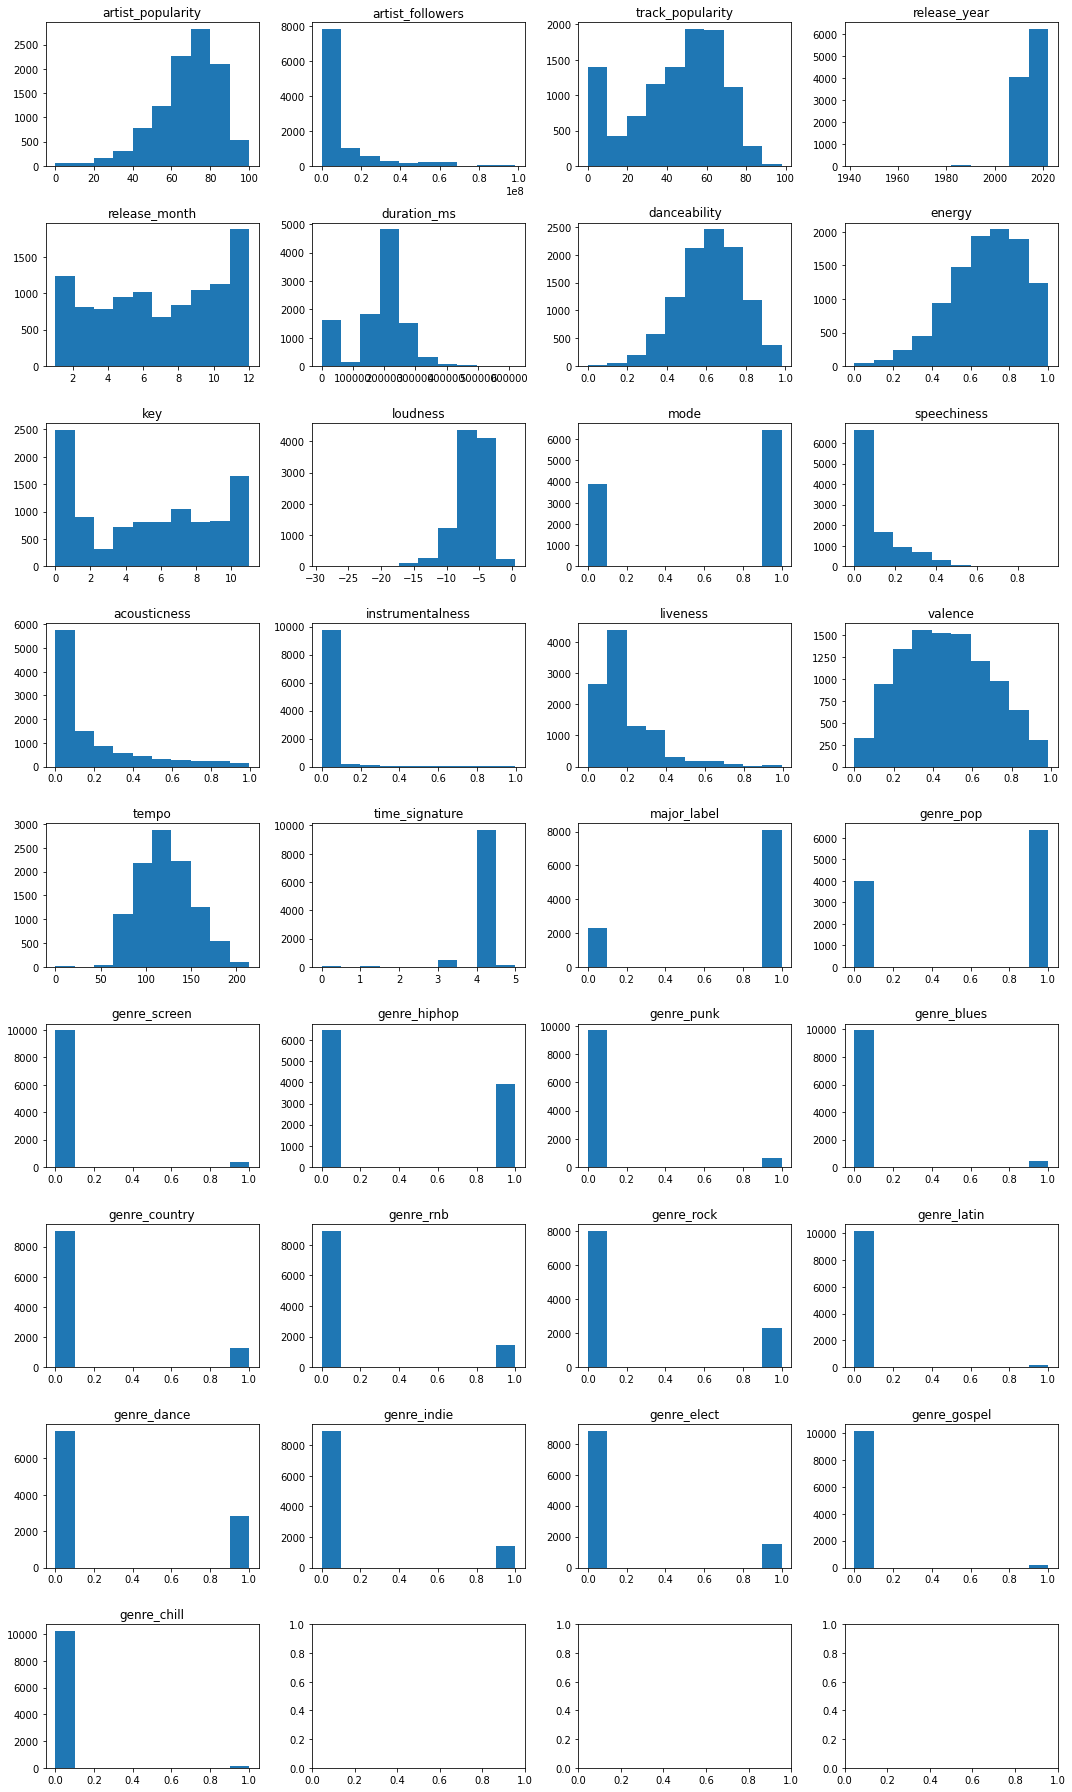

In [36]:
# let's look at the feature distributions again
i = 1
plt.subplots(9,4,figsize=(15,25))

for column in X_train.columns:
    plt.subplot(9,4,i)
    plt.hist(X_train[column])
    plt.title(f'{column}')
    i += 1

plt.tight_layout()
plt.show()

This is a lengthy process. Comments are written for each code.

In [37]:
# assign columns for StandardScaler()
std_cols = ['artist_popularity', 'track_popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'valence',
           'tempo'] 

# create a pipeline
std_cols_transform = Pipeline([('scaler', StandardScaler())], memory=cachedir)

# assign columns for MinMaxScaler()
mm_cols = ['artist_followers', 'release_year', 'release_month', 'key', 'mode', 'speechiness', 'acousticness',
           'instrumentalness', 'liveness', 'time_signature', 'major_label', 'genre_pop', 'genre_screen', 'genre_hiphop',
          'genre_punk', 'genre_blues', 'genre_country', 'genre_rnb', 'genre_rock', 'genre_latin', 'genre_dance', 
           'genre_indie', 'genre_elect', 'genre_gospel', 'genre_chill']

# create a pipeline
mm_cols_transform = Pipeline([('scaler', MinMaxScaler())], memory=cachedir)

# instantiate ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[('standard', std_cols_transform, std_cols),
                  ('minmax', mm_cols_transform, mm_cols)])

# set up pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# run a grid search
param_grid = [{
    'model__C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000],
    'model__penalty': ['l1', 'l2'],
    'model__solver' : ['saga', 'lbfgs']
}]

# set up gridsearch cross validation
grid = GridSearchCV(pipe, param_grid, cv=5)

# fit train set
fittedgrid = grid.fit(X_train, y_train)

In [38]:
# Best estimator object
fittedgrid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('standard',
                                                  Pipeline(memory='C:\\Users\\eunji\\AppData\\Local\\Temp\\tmp9dk_f5ou',
                                                           steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['artist_popularity',
                                                   'track_popularity',
                                                   'duration_ms',
                                                   'danceability', 'energy',
                                                   'loudness', 'valence',
                                                   'tempo']),
                                                 ('minmax',
                                                  Pipeline(memory='C:\\Users\\eunji\\AppData\\Loca...
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'time_signature',
                                                   'major_label', 'genre_pop',
                                                   'genre_screen',
                                                   'genre_hiphop', 'genre_punk',
                                                   'genre_blues',
                                                   'genre_country', 'genre_rnb',
                                                   'genre_rock', 'genre_latin',
                                                   'genre_dance', 'genre_indie',
                                                   'genre_elect',
                                                   'genre_gospel',
                                                   'genre_chill'])])),
                ('model',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [39]:
fittedgrid.best_params_

{'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'saga'}

In [40]:
print(f'Best train score: {round(fittedgrid.score(X_train, y_train)*100, 1)}%')
print(f'Best test score: {round(fittedgrid.score(X_test, y_test)*100, 1)}%')

Best train score: 81.1%
Best test score: 81.1%


Our train score increased by +0.1% percentage point, but otherwise overall scores are very similar to when we scaled the entire dataframe with StandardScaler(). We can conclude that our dataframe is minimally impact by type of scaler.

---
### Precision and Recall Scores (Supplementary)<a class="anchor" id="precision"></a>

So far, we've been measuring our models by the overall accuracy score (correct predictions of total predictions). But exactly how precise were the model's predictions? Or in other words, how many of the model's predictions were incorrect? This is where our precision, recall, and F1 scores come in -- all of which are built in sklearn. These metrics are more useful for imbalanced class data. Luckily, our dataset was balanced during the data acquisition phase, so these calculations are supplementary.

In the confusion matrix below, we will consider `billboard == 0` as a "cold" song and `billboard == 1` as a "hot" song.

|                       |  Predicted: Cold ❄️ |   Predicted: Hot 🔥 | 
|:---------------------:|:-------------------------:|:---------------------------:|
|<b>Actually: Cold ❄️ </b>|**TN**<br>(True Negative)<br><br> Correctly predicted a cold song. | **FP**<br>(False Positive)<br><br> Incorrectly predicted a hot song. | 
|<b>Actually: Hot 🔥 </b>|**FN**<br>(False Negative)<br><br>Incorrected predicted a cold song. |**TP**<br>(True Positive)<br><br>Correctly predicted a hot song.| 

The formulas are below but sklearn has built-in functions which we will run in the cells below.

$$Precision = \frac{TP}{TP+FP}$$
<center>(% of total positive predictions were actually positive)</center>
<br>
<br>
$$Recall = \frac{TP}{TP+FN}$$
<center>(% of total positive actuals were predicted as positive)</center>

---

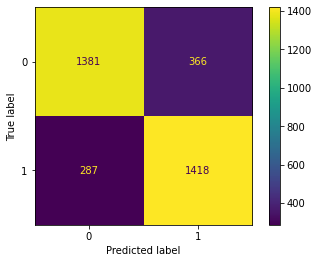

In [41]:
# plot the y_test prediction and actual results
plot_confusion_matrix(fittedgrid, X_test, y_test)
plt.show()

In [42]:
# obtain predictions on test set
y_pred = fittedgrid.predict(X_test)

# calculate precision, recall, F1 scores
print(f'Precision Score: {round(precision_score(y_test, y_pred)*100,1)}%')
print(f'Recall Score: {round(recall_score(y_test, y_pred)*100,1)}%')
print(f'F1 Score: {round(f1_score(y_test, y_pred)*100,1)}%')

Precision Score: 79.5%
Recall Score: 83.2%
F1 Score: 81.3%


It looks like our precision score was slightly below our recall score. Another way of understanding this is that the model "over-predicts" songs that belong on the Billboard, leading to more False Positives. On the other hand, of all songs actually on the Billboard, we correctly identified 83.2% of them. Overall, all these scores are very close to our best test score accuracy of 81.2%.

---

<center>2022 BrainStation Capstone Project
    <br>"Is the song <i>hot enough</i> for Billboard Hot100?"
    <br>by Hailey Lee</center>